
<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy - SHAP model explainability</center></h2>
![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png)

In this work, I'll train a baseline ResNet50, evaluate the model, and use SHAP model explainability technique to help us better understand our model's predictions, and how we could further improve its performance.

#### About [SHAP](https://github.com/slundberg/shap) from its source:

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png" width="400">

##### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our [papers](https://github.com/slundberg/shap#citations) for details).

In [19]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dependencies

In [20]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [21]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [4]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [22]:
# direktori dataset
dataset_path = "/content/drive/MyDrive/DFU_Dataset"

## Load data

In [23]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                fill_mode='nearest',
                zoom_range=2,  # set range for random zoom
                rotation_range = 90,
                shear_range = 0.4,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True
)

validation_datagen = ImageDataGenerator(
                rescale=1./255,
                fill_mode='nearest',
                zoom_range=2,  # set range for random zoom
                rotation_range = 90,
                shear_range = 0.4,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True
)

test_datagen = ImageDataGenerator(
                rescale=1./255
)

# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [24]:
labels = ['Ulcer','Healthy']

In [25]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/train',
                                              target_size = (224,224),
                                              batch_size=2,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=4,
                                              interpolation='bilinear'
                                              )

valid_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/validation',
                                                   target_size=(224,224),
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed=5,
                                                   interpolation='bilinear'
                                                   )

test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/DFU_Dataset/test',
                                            target_size=(224,224),
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=True,
                                            )

Found 757 images belonging to 2 classes.
Found 85 images belonging to 2 classes.
Found 211 images belonging to 2 classes.


# Model

In [26]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.models import Model, load_model
import pydot
from keras.utils.vis_utils import plot_model
from matplotlib.pyplot import imshow

In [27]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [28]:
input_shape = (224, 224, 3)
inputs = Input(input_shape)
 
dense   = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
nas      = tf.keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

In [29]:
multi_net = Concatenate()([GlobalAveragePooling2D()(dense), GlobalAveragePooling2D()(nas), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(multi_net)
outputs = BatchNormalization()(outputs) 
outputs = Dense(128,activation='relu')(outputs) 
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs) 
predicts = Dense(2, activation='softmax')(outputs)
model = Model(inputs, predicts)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 7, 7, 1920)   18321984    ['input_5[0][0]']                
                                                                                                  
 NASNet (Functional)            (None, 7, 7, 1056)   4269716     ['input_5[0][0]']                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_5[0][0]']          

In [32]:
import tensorflow as tf
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= 'accuracy')

In [33]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("VGG16.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(train_generator,  
                    epochs=5,
                    validation_data = valid_generator,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5


# Train top layers

# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models): 
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

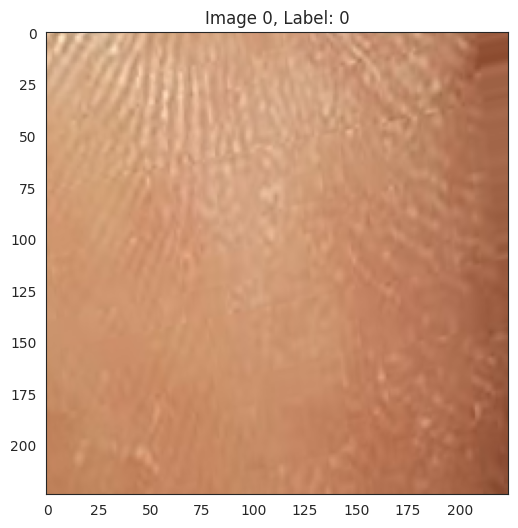

In [17]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[6, 6])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

In [18]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


ResourceExhaustedError: ignored

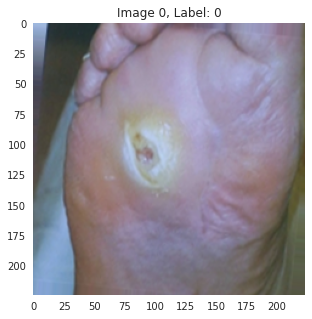

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

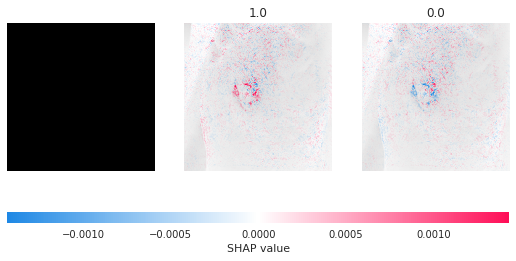

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

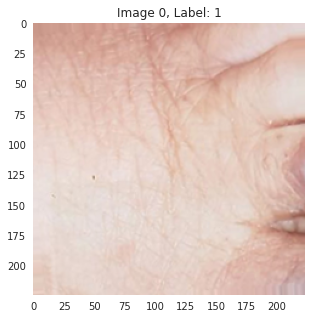

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

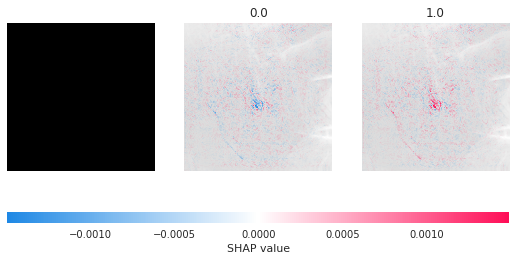

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

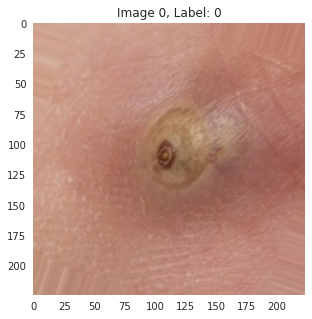

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

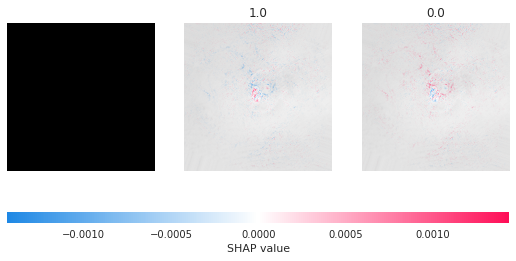

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

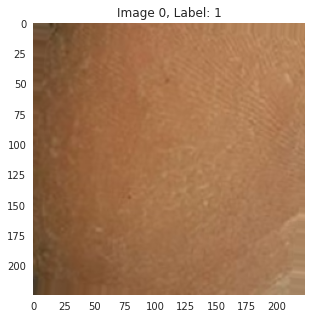

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

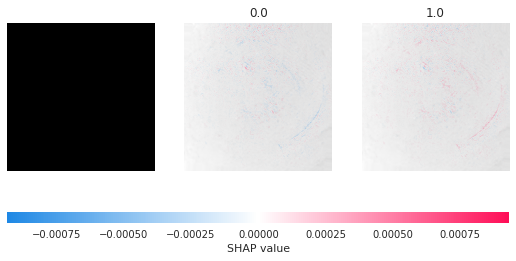

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

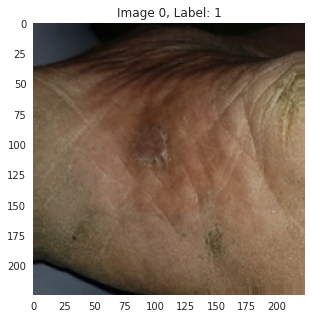

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

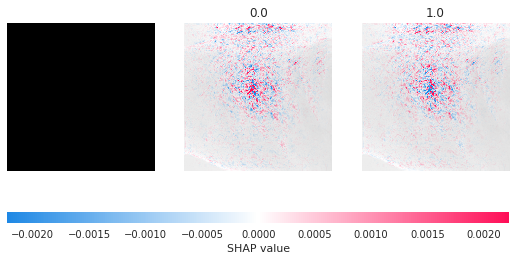

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

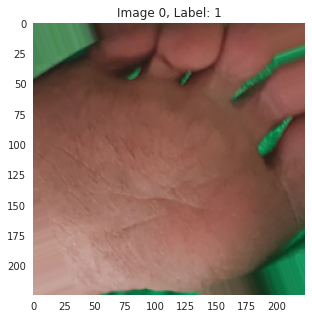

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

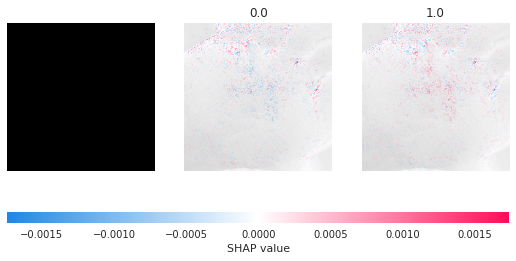

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

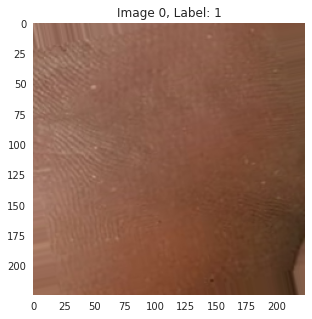

In [ ]:
n_explain = 1
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[5, 5])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

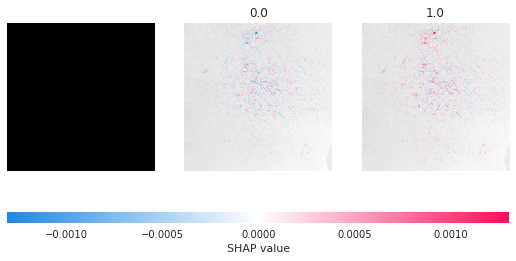

In [ ]:
# explain predictions of the model on "n_explain" images
e = shap.GradientExplainer(model, background)
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)